## Задачи: 
### 1. Обучить модель на языке Python для классификации отзывов.
### 2. Разработать веб-сервис на базе фреймворка Django для ввода отзыва о фильме с автоматическим присвоением рейтинга (от 1 до 10) и статуса комментария (положительный или отрицательный).
### 3. Развернуть сервис в открытом доступе для оценки работоспособности прототипа.
### 4. Подготовить отчет о работе с оценкой точности полученного результата на тестовой выборке.
### 5. Отправить ответным письмом ссылку на прототип сервиса, ссылку на открытый репозиторий github с исходным кодом проекта, отчет о проделанной работе в формате pdf.


## Задача 1: 

### 0. Импорт, установка нужных библиотек и модулей.

In [222]:
#общие библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#для инпута
import re, glob, os
from sklearn.datasets import load_files

#для обработки и чистки данных
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words("english"))
from sklearn.model_selection import train_test_split

#для визуализации распределения слов в тексте
from wordcloud import WordCloud

#для подбора модели и гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

#для представления текста в виде числовых данных
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#модели машинного обучения
import xgboost as xg
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#метрики для оценки моделей
from sklearn.metrics import mean_absolute_error, confusion_matrix

#для применения Django
import pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\izmec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\izmec\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\izmec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\izmec\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 1. Инпут.

In [2]:
path_test = r'C:/My little home/Kind of life/Job/Тестовые/гринатом/data/test/f/'
path_train = r'C:/My little home/Kind of life/Job/Тестовые/гринатом/data/train/f/'
path_train_uns = r'C:/My little home/Kind of life/Job/Тестовые/гринатом/data/train/unsup/'

In [3]:
def input_sup(path):
    data = load_files(path)
    X, y = data.data, data.target
    z = []
    for data in data.filenames:
        z.append(re.findall("_(\d+).txt", data))
    z = [int(i[0]) for i in z]
    df = pd.DataFrame({'data': X, 'target': y, 'target_rang': z})
    df = df.astype({"data": str, "target": int, "target_rang": 'int32'})
    return df

In [4]:
def input_unsup(path):
    file_list = glob.glob(path + '/*.txt')
    data = []
    for file in file_list:
        data.append(str(np.loadtxt(file, dtype="str", delimiter="\0", encoding="utf-8")))
    df = pd.DataFrame({'data': data})
    return df

In [5]:
%%time
train_data_sup = input_sup(path = path_train)
test_data = input_sup(path = path_test)
train_data_unsup = input_unsup(path = path_train_uns)

C:\Users\izmec\AppData\Local\Temp\ipykernel_6180\2810261159.py:5: UserWarning: loadtxt: input contained no data: "C:/My little home/Kind of life/Job/Тестовые/гринатом/data/train/unsup\26984_0.txt"
  data.append(str(np.loadtxt(file, dtype="str", delimiter="\0", encoding="utf-8")))
C:\Users\izmec\AppData\Local\Temp\ipykernel_6180\2810261159.py:5: UserWarning: loadtxt: input contained no data: "C:/My little home/Kind of life/Job/Тестовые/гринатом/data/train/unsup\7655_0.txt"
  data.append(str(np.loadtxt(file, dtype="str", delimiter="\0", encoding="utf-8")))


CPU times: total: 1min
Wall time: 8min 37s


### 2. Preproccesing: чистка, лемматизация, тэги частей речи текста.

In [6]:
def preprocess(text):
    Apos_dict={"'s":" is","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are", "U": "you"}
    for key, value in Apos_dict.items():
        if key in text:
            text = text.replace(key,value)
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub("b'", "", text)
    text = re.sub('\\\\', r'', text, re.MULTILINE)
    text = re.sub('b"', "", text)
    text = re.sub("<br />", "", text)
    text = text.replace("b", "", 1)
    return text

 
# удаление стоп-слов
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [7]:
%%time
lemmatizer= WordNetLemmatizer()
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
train_data_sup['clean_text'] = train_data_sup['data'].apply(lambda x: finalpreprocess(x))
train_data_sup.head()

CPU times: total: 25min 53s
Wall time: 25min 56s


,data,target,target_rang,clean_text
0,"b""Zero Day leads you to think, even re-think w...",1,10,zero day lead think even think two boy young m...
1,b'Words can\'t describe how bad this movie is....,0,1,word describe bad movie explain write see get ...
2,b'Everyone plays their part pretty well in thi...,1,10,everyone play part pretty well little nice mov...
3,b'There are a lot of highly talented filmmaker...,0,1,lot highly talented filmmaker actor germany no...
4,b'I\'ve just had the evidence that confirmed m...,0,2,evidence confirm suspicion bunch kid put dvd t...


In [8]:
test_data['clean_text'] = test_data['data'].apply(lambda x: finalpreprocess(x))
test_data.head()

,data,target,target_rang,clean_text
0,"b""Don't hate Heather Graham because she's beau...",1,9,hate heather graham beautiful hate fun watch m...
1,b'I don\'t know how this movie has received so...,0,1,know movie receive many positive comment one c...
2,"b""I caught this movie on the Horror Channel an...",1,8,caught movie horror channel quite impressed fi...
3,b'NBC had a chance to make a powerful religiou...,0,1,nbc chance make powerful religious epic along ...
4,"b""Looking for something shocking? Okay fine......",0,1,look something shock okay fine imagery film at...


### 3. Посмотрим на данные:

Соотношение количества оценок рейтинга в тренировочном наборе.

In [9]:
train_data_sup.target_rang.value_counts() / train_data_sup.shape[0] *100

1     20.400
10    18.928
8     12.036
4     10.784
7      9.984
3      9.680
2      9.136
9      9.052
Name: target_rang, dtype: float64

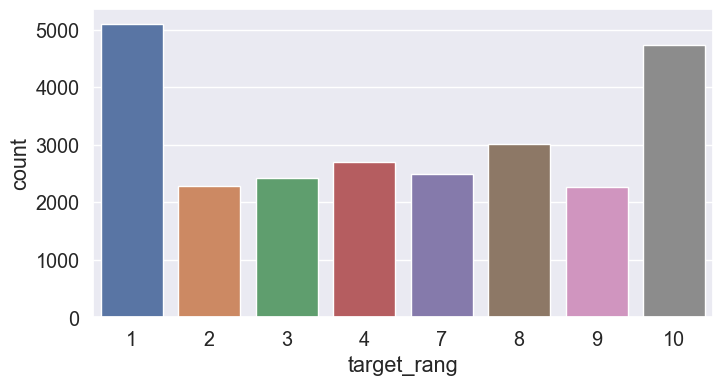

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(x='target_rang', data=train_data_sup);

Чистка дубликатов в тренировочном наборе.

In [11]:
index = train_data_sup[train_data_sup.duplicated() == True].index
train_data_sup.drop(index, axis = 0, inplace = True)
train_data_sup.reset_index(inplace=True, drop = True)

Соотношение количества оценок рейтинга в тестовом наборе.

In [12]:
test_data.target_rang.value_counts()

1     5022
10    4999
8     2850
4     2635
3     2541
9     2344
7     2307
2     2302
Name: target_rang, dtype: int64

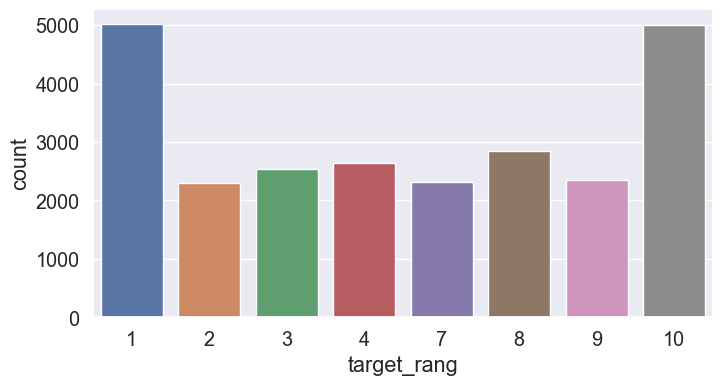

In [13]:
plt.figure(figsize=(8,4))
sns.countplot(x='target_rang', data = test_data);

Распределение соответствует (наглядно) с тренировочным набором.

Удаление дубликатов:

In [14]:
index = test_data[test_data.duplicated() == True].index
test_data.drop(index, axis = 0, inplace = True)
test_data.reset_index(inplace=True, drop = True)

Также можно посмотреть на графическое представление распределение слов в положительных и отрицательных отзывах.

Positive Words


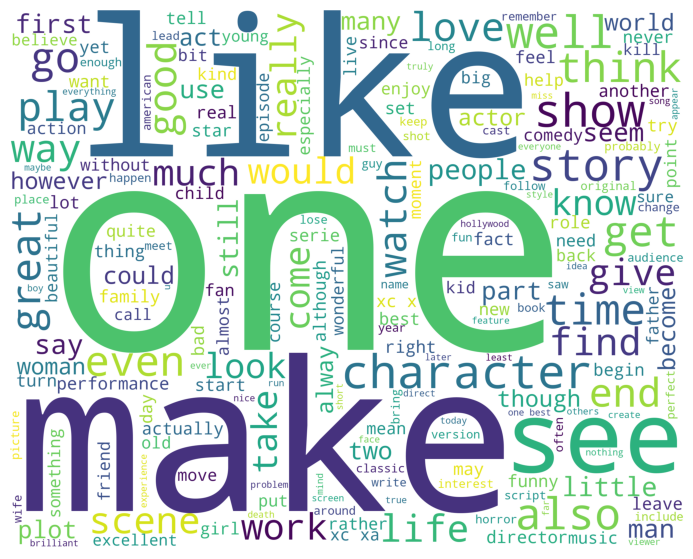

Negative Words


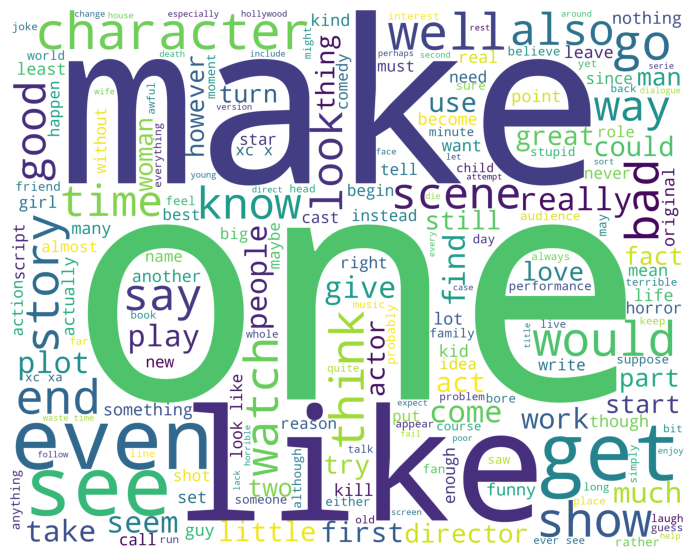

In [66]:
from wordcloud import WordCloud
positivedata = train_data_sup[train_data_sup['target'] == 1]
positivedata = positivedata['clean_text']
negdata = train_data_sup[train_data_sup['target'] == 0]
negdata = negdata['clean_text']
def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                              if(word!='movie' and word!='film')
                            ])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive Words")
wordcloud_draw(positivedata)
print("Negative Words")
wordcloud_draw(negdata)

### 4. Разделим тренировочный набор, добавив набор для валидации.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data_sup['clean_text'], train_data_sup['target_rang'], 
                                                 test_size=0.2, random_state=42)

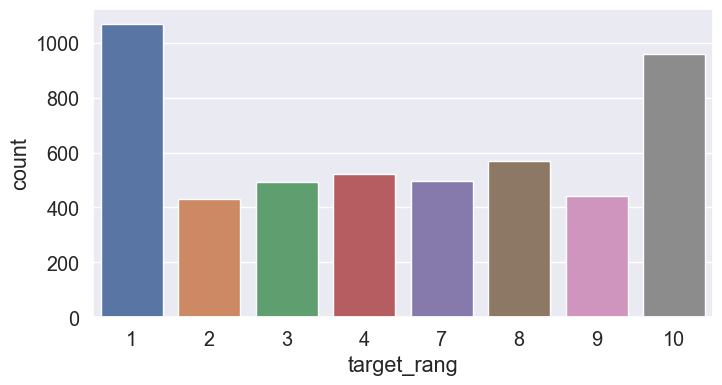

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x=y_val);

Разделим тестовый набор на отдельные переменные.

In [17]:
X_test = test_data.iloc[:,3]
y_test = test_data.iloc[:,2]

### 5. Проведём перевод текста в численные представления.

In [83]:
X_train_tok = [nltk.word_tokenize(i) for i in X_train]  
X_test_tok = [nltk.word_tokenize(i) for i in X_test]
X_val_tok = [nltk.word_tokenize(i) for i in X_val]

In [261]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#построим Word2Vec модель
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
model = Word2Vec(X_train_tok, min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

#конвертируем текст в вектора
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [217]:
vectorizer = CountVectorizer()
X_train_vectors_cv = vectorizer.fit_transform(X_train)
X_val_vectors_cv = vectorizer.transform(X_val)
X_test_vectors_cv = vectorizer.transform(X_test)

### 6. Обучим модели машинного обучения предсказывать рейтинг от 1 до 10.

Будем использовать методы машинного обучения: случайные леса, логистическая регрессия, градиентный бустинг и экстремальный градиентный бустинг. Для подбора гиперпараметров используем случайный поиск. 

Подбор будем проводить по трём числовым представлениям: countvectorizer, tf-idf и word2vec.

In [210]:
reg1 = RandomForestRegressor(random_state=42)
reg2 = LogisticRegression(random_state=42)
reg3 = GradientBoostingRegressor(random_state=42)
reg4 = xg.XGBRegressor(random_state = 42)

In [202]:
param1 = {}
param1['regressor__n_estimators'] = [10, 50, 100, 250]
param1['regressor__max_depth'] = [5, 10, 20]
param1['regressor__max_features'] = ["sqrt", "log2"]
param1['regressor'] = [reg1]

param2 = {}
param2['regressor__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['regressor__penalty'] = ['l1', 'l2']
param2['regressor__dual'] = [True, False]
param2['regressor__max_iter'] = [100, 500, 1000, 2000, 5000]
param2['regressor__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['regressor'] = [reg2]

param3 = {}
param3['regressor__n_estimators'] = [10, 50, 100, 250]
param3['regressor__max_depth'] = [5, 10, 20]
param3['regressor'] = [reg3]

param4 = {}
param4['regressor__learning_rate'] = sp_randFloat()
param4['regressor__subsample'] = sp_randFloat()
param4['regressor__n_estimators'] = sp_randInt(100, 2000)
param4['regressor__max_depth'] = sp_randInt(1, 10)
param4['regressor'] = [reg4]

In [203]:
pipeline = Pipeline([('regressor', reg1)])
params = [param1, param2, param3, param4]

In [205]:
%%time
rs_w2v = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error').fit(X_train_vectors_w2v, 
                                                                                                      y_train)

CPU times: total: 1min 48s
Wall time: 11min 2s


In [208]:
%%time
rs_tfidf = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error').fit(X_train_vectors_tfidf, 
                                                                                                        y_train)

CPU times: total: 4min 42s
Wall time: 20min 46s


In [218]:
%%time
rs_cv = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error').fit(X_train_vectors_cv, 
                                                                                                     y_train)

CPU times: total: 6min 42s
Wall time: 24min 22s


### Оценка регрессоров.

In [207]:
rs_w2v.best_score_

-1.9221659619773386

In [235]:
mean_absolute_error(rs_w2v.best_estimator_.predict(X_test_vectors_w2v), y_test)

1.9475643883612914

In [211]:
rs_tfidf.best_score_

-1.8919812188507545

In [233]:
mean_absolute_error(rs_tfidf.best_estimator_.predict(X_test_vectors_tfidf), y_test)

1.8707214427123438

In [219]:
rs_cv.best_score_

-1.904724142358959

In [231]:
mean_absolute_error(rs_cv.best_estimator_.predict(X_test_vectors_cv), y_test)

1.8949086058356024

Наименьшая ошибка у представления tf-idf.

### Оценка классификации.

Также посмотрим, как предсказывает модель классы: негативный или позитивный отзыв. Сделаем confusion matrix.

In [276]:
pred = final_model.predict(X_test_vectors_tfidf)
pred_hard = np.array([round(p) for p in pred])
pred_hard[pred_hard < 1] = 1
pred_hard[pred_hard > 10] = 10

In [294]:
pred_hard = np.array(pred_hard)
y_test = np.array(y_test)

pos_true = 0
pos_fal = 0
neg_true = 0
neg_fal = 0

In [308]:
from sklearn.metrics import precision_recall_curve

In [295]:
for i in range(len(y_test)):
    
    if ((y_test[i] > 5) & (pred_hard[i] > 5)):
        pos_true += 1

    if ((y_test[i] < 6) & (pred_hard[i] > 5)):
        pos_fal += 1
    
    if ((y_test[i] < 6) & (pred_hard[i] < 6)):
        neg_true += 1
    
    if ((y_test[i] > 5) & (pred_hard[i] < 6)):
        neg_fal += 1

In [298]:
mat = np.array([[pos_true, pos_fal], [neg_fal, neg_true]])

In [299]:
mat

array([[10804,  2453],
       [ 1639,  9908]])

Также покажем кривую точности-полноты.

In [305]:
y_true_pn = test_data.iloc[:,1]

In [301]:
y_test_pn = np.zeros(len(pred_hard))
for i in range(len(pred_hard)):
    if pred_hard[i] > 5:
        y_test_pn[i] = 1
    else:
        y_test_pn[i] = 0

In [309]:
precision, recall, thresholds = precision_recall_curve(y_true_pn, y_test_pn)

In [311]:
from sklearn.metrics import PrecisionRecallDisplay

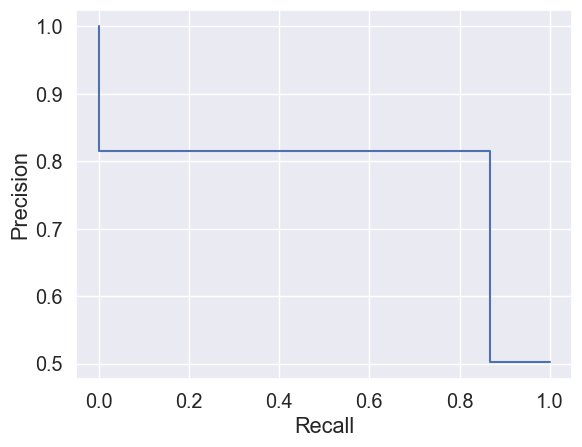

In [313]:
display = PrecisionRecallDisplay(
            recall=recall,
            precision=precision,
            )
display.plot()

Проверим работы на примере:

In [266]:
sample = ["This was good. I don't really know maybe it was bad, but it feels comfortable"]

def output (text):
    text = tfidf_vectorizer.transform(sample)
    rat = round(final_model.predict(text)[0])
    print('Ваша оценка: ', rat)
    if rat < 6:
        print ('Негативная оценка')
    else:
        print ('Позитивная оценка')

In [267]:
output(sample)

Ваша оценка:  4
Негативная оценка


In [316]:
pd.to_pickle(final_model, 'C:/My little home/Kind of life/Job/Тестовые/гринатом/fm.pkl')

In [174]:
vectorizer = TfidfVectorizer(use_idf=True)

In [318]:
pickl = {
    'vectorizer': vectorizer,
    'final_model': final_model
}
pickle.dump(pickl, open( 'models' + ".p", "wb" ) )

Я не задеплоила модель на Django, но пробовала сделать это. Пока что это моя точка роста.

Пробовала больше моделей (в том числе нейронные сети), здесь представила только лучшие из них.

Большое спасибо за внимание. Хотелось бы услышать фидбек.